### Abstract

In this blog post we'll be looking at data from a bank. We'll start with some data exploration and visualization to get a better understanding of the features in the dataset. Our ultimate goal here is to create a decision-making system that will determine whether a prospective borrower should be offered a loan. We will use logistic regression to assign weights to different features in the dataset, which we will then use to give each prospective borrower a "score". This score will be used to determine whether the borrower will prospective receive a loan based on a threshold that will optimize profits for the bank. After creating this decision-making system, we'll test it out on a test dataset and do some exploration into who our system predicted would be able to repay their loans, and who it predicted wouldn't.  


In [1]:
#| include: false

# Imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


In [2]:
# Read in the data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [3]:
#| echo: false
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


### Exploring The Data

Let's start with some visualizations to explore patterns in this dataset:

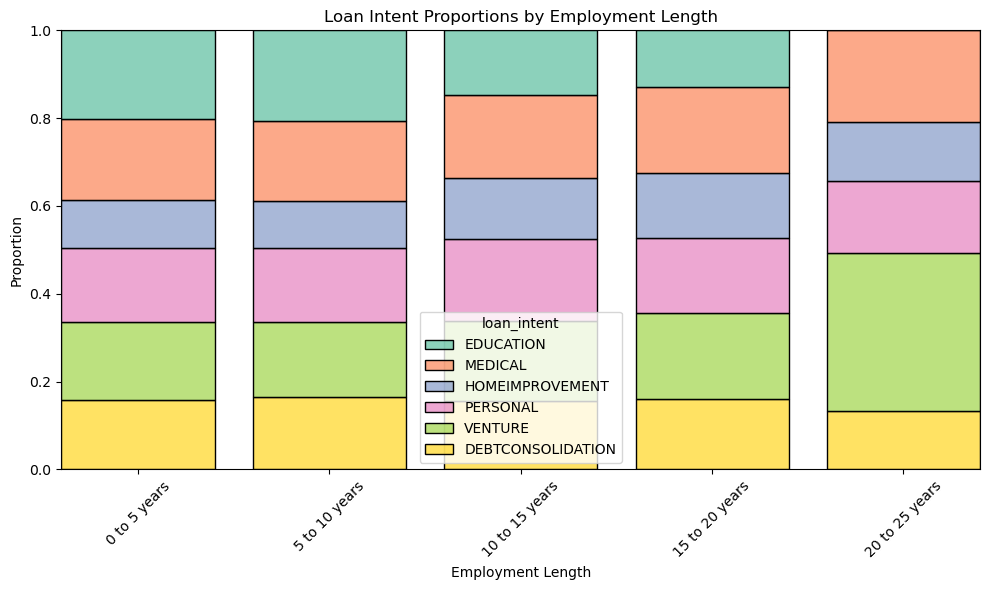

In [4]:
#| code-fold: true
#| code-summary: "Plotting Code"
#| label: loan-intent-employment
#| fig-cap: "Figure 1: Loan intent by length of employment"

# Filter out rows with employment length greater than 25 years
df_train = df_train[df_train['person_emp_length'] <= 25]

# Bucket the employment length into 5-year chunks
bins = range(0, 25 + 5, 5)
labels = ["0 to 5 years", "5 to 10 years", "10 to 15 years", "15 to 20 years", "20 to 25 years"]

df_train['emp_length_bucket'] = pd.cut(
    df_train['person_emp_length'],
    bins=bins,
    right=True,
    labels=labels,
    include_lowest=True
)

# Create a Seaborn plot using histplot with multiple="fill" for normalized (proportional) stacked bars
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_train,
    x='emp_length_bucket',
    hue='loan_intent',
    multiple='fill',  # normalizes each bar to sum to 1 (proportions)
    shrink=0.8, 
    palette="Set2"
)
plt.title("Loan Intent Proportions by Employment Length")
plt.xlabel("Employment Length")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Loan Interest Rate')

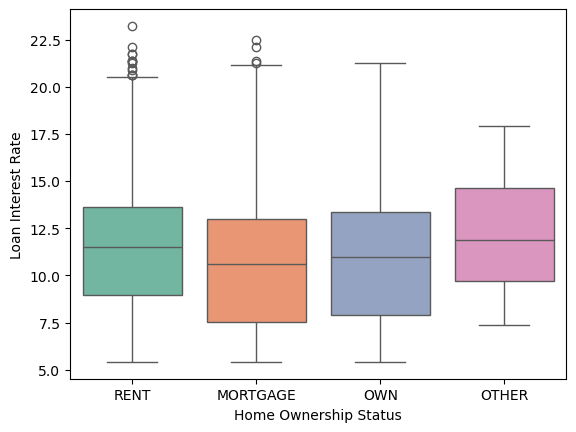

In [5]:
#| code-fold: true
#| code-summary: "Plotting Code"
#| label: interest-rate-home-ownership
#| fig-cap: "Figure 2: Interest rate distribution by home ownership status"

# Plot the distribution of interest rates of each of the home ownership statuses 
sns.boxplot(data=df_train, x="person_home_ownership", y="loan_int_rate", palette="Set2")
plt.xlabel("Home Ownership Status")
plt.ylabel("Loan Interest Rate")

In [6]:
#| echo: false
#| label: credit-history-mean-length
#| fig-cap: "Figure 3: mean credit history length by loan grade"

# Use group by to make a table of the average culmen length by species 
grouped_data = df_train.groupby("loan_grade").agg({"cb_person_cred_hist_length" : "mean"})
grouped_data["cb_person_cred_hist_length"] = grouped_data["cb_person_cred_hist_length"].round(1)
grouped_data = grouped_data.rename(columns={"loan_grade":"Loan Grade", "cb_person_cred_hist_length":"credit_history_length"})
grouped_data

,credit_history_length
loan_grade,
A,5.7
B,5.8
C,5.9
D,5.8
E,5.8
F,6.1
G,6.6


We're looking here to understand some of the patterns in this dataset. 

 First, in Figure 1, we can see that borrowers' intentions for their loans change a bit as the length of their employment increases. Specifically, after 20 years of employment people stop borrowing to pay for education, which makes sense. People also start taking out more loans for venture and medical uses as their employment goes on. It looks like the proportion of loans that are intended to be used for home improvement, personal reasons, and debt consolidation remain fairly constant across length of employment. 
 
 Moving on to Figure 2, we can see that borrowers with different home ownership statuses (renting, owning, mortgaging or other), have differences in the interest rate they might receive on their loan. Borrowers who rent their home seem more likely to have an interest rate of over 20%, and we can see that borrowers who own their homes rarely see interests rates over 20%. Borrowers who rent and mortgage their homes have more variability in the interest rates they might see, as well. 

Finally, we can see in Figure 3 that loan grades have differences in average length of credit of the borrower. It seems that borrowers with higher loan grades have longer credit histories, on average. 

We can see that we should be able to get some information about whether a borrower will pay back a loan from some of these features. 

#### Prepping the Data

In [7]:
# Encode the qualitative variables quantitatively
def preprocess(df):
    """
    Function to preprocess the data
    """
    le_home = LabelEncoder()
    df["person_home_ownership"] = le_home.fit_transform(df["person_home_ownership"])

    le_intent = LabelEncoder()
    df["loan_intent"] = le_intent.fit_transform(df["loan_intent"])
    intent_mapping = dict(zip(le_intent.transform(le_intent.classes_), le_intent.classes_))

    df = pd.get_dummies(df, columns=['cb_person_default_on_file'], prefix='default')
    df = df.dropna()

    # Change the interest rate column to a percentage
    df["loan_int_rate"] = df["loan_int_rate"]/100

    #Filter out columns with weird values
    df = df[(df["person_age"] < 100) & (df["person_income"] > 1000) &  (df["loan_int_rate"] > 0)]

    # Separate our the target variable
    y = df["loan_status"]

    return df, y, intent_mapping

df_train_clean, y_train, intent_map = preprocess(df_train)

We will use this function prepare our datasets for analysis. We're encoding the qualitative columns for home ownership and loan intent as integers,  one-hot encoding the historical default true/false column as 0s and 1s, separating the target variable

### Building A Model 

#### Choosing Features

First, let's figure out which features we want to use for the model. We'll generate a few new features that we can use to better understand the relationships between our features:
- Credit history ratio: $\frac{\text{credit history length}}{\text{age}}$
- Employment stability: $\frac{\text{employment length}}{\text{age}}$
- Income stability: $\text{income}*\text{employment length}$

 We'll use cross validation to test a few combinations of features: 
1. Employment stability, income, and percentage of income that the loan is
2. Loan intent, credit history ratio, home ownership status
3. income stability, loan interest rate, age

In [8]:
# Create new features 
def new_features(df):
    df["credit_history_ratio"] = round(df["cb_person_cred_hist_length"]/df["person_age"],2)
    df["employment_stability"] = round(df["person_emp_length"]/df["person_age"], 2)
    df["income_stability"] = round(df["person_income"]*df["person_emp_length"],2)
    return df
df_train_clean = new_features(df_train_clean)

In [9]:
# Define three different sets of features
feature_sets = {
    "Set 1": ["employment_stability", "person_income", "loan_percent_income"],
    "Set 2": ["loan_intent", "credit_history_ratio", "person_home_ownership"],
    "Set 3": ["income_stability", "loan_int_rate", "person_age"]
}

model = LogisticRegression()

# Evaluate each feature set
results = {}
for set_name, features in feature_sets.items():
    X_train = df_train_clean[features]
    X_train = StandardScaler().fit_transform(X_train)  # Standardize features 
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    results[set_name] = mean_accuracy
    print(f"{set_name}: Mean Accuracy = {mean_accuracy:.4f}")

Set 1: Mean Accuracy = 0.8246
Set 2: Mean Accuracy = 0.7850
Set 3: Mean Accuracy = 0.8095


#### Estimating weights

After fitting an LR to each of the feature sets and using cross validation to test how accurate the models are, we can see that our first set of features, which includes employment stability, income, and percentage of income that the loan is has the highest average accuracy. Now, we'll fit an LR model to these features to obtain our vector of weights that we'll use in our scoring function. 

In [10]:
weights_model = LogisticRegression()
X_train = df_train_clean[feature_sets["Set 1"]]
X_train = StandardScaler().fit_transform(X_train)
weights_model.fit(X_train, y_train)

for feature, coef in zip(feature_sets["Set 1"], weights_model.coef_[0]):
    print(f"{feature}: {coef:.4f}")

employment_stability: -0.1482
person_income: -0.4953
loan_percent_income: 0.7925


Now we can use these coefficients in our as the values in our weight vector when we create a scoring function, which we'll do next. 

### Creating the score function

Our next step is to give each borrower a score, using the features and weights that we decided on above. We'll add a "score" column to the train set that has the result of our score function: 

$\text{score} = -0.1482 * x_1 - 0.4953 * x_2 + 0.7925 * x_3$

where 

$x_1$ = employment_stability

$x_2$ = person_income

$x_3$ = loan_percent_income

In [11]:
def score_dataframe(df):
    """
    Compute the score for each borrower using the weights 
    determined by the logistic regression

    inputs:
    df: Pandas DataFrame with all features used to generate weights
    and loan status, amount, and interest rate for profit calculations
    """
    df_scored = df.copy()
    df_scored[["employment_stability", "person_income", "loan_percent_income"]] = StandardScaler().fit_transform(df_scored[["employment_stability", "person_income", "loan_percent_income"]])
    df_scored["score"] =  round(-0.1486 * df_scored["employment_stability"] - 0.6252 * df_scored["person_income"] + 0.7925 * df_scored["loan_percent_income"],2)
    return df_scored

In [12]:
def compute_profit(threshold, df):
    """
    Compute the profit that the bank would have made if they had
    used the predictions determined by our score function
    and threshold

    inputs:
    threshold: integer value for score threshold 
    df: Pandas DataFrame with loan amount, interest rate, actual loan status, and score from 
    scoring function
    """
    df["pred_default"] = df["score"].apply(lambda x: 1 if x > threshold else 0)
    
    # Calculate potential profit for repayment or defaulting 
    df["repaid_profit"] = round(df["loan_amnt"] * (1 + 0.25 * df["loan_int_rate"])**10 - df["loan_amnt"],2)
    df["defaulted_profit"] = round(df["loan_amnt"] * (1 + 0.25 * df["loan_int_rate"])**3 - 1.7 * df["loan_amnt"],2)
    
    # Profit based on actual loan status versus predicted status
    df["profit"] = 0  # Default to zero profit
    df.loc[(df["loan_status"] == 0) & (df["pred_default"] == 0), "profit"] = df["repaid_profit"]  # Successful repayment
    df.loc[(df["loan_status"] == 1) & (df["pred_default"] == 0), "profit"] = df["defaulted_profit"]  # Incorrectly predicted as good loan, default
    df.loc[(df["loan_status"] == 1) & (df["pred_default"] == 1), "profit"] = 0  # Correctly predicted as default, no profit
    df.loc[(df["loan_status"] == 0) & (df["pred_default"] == 1), "profit"] = 0  # Incorrectly predicted as default, no profit

    return sum(df["profit"]) / len(df)


Optimal Threshold for Maximum Profit: 1.1500
Maximum profit per prospective borrower: 1316.4800


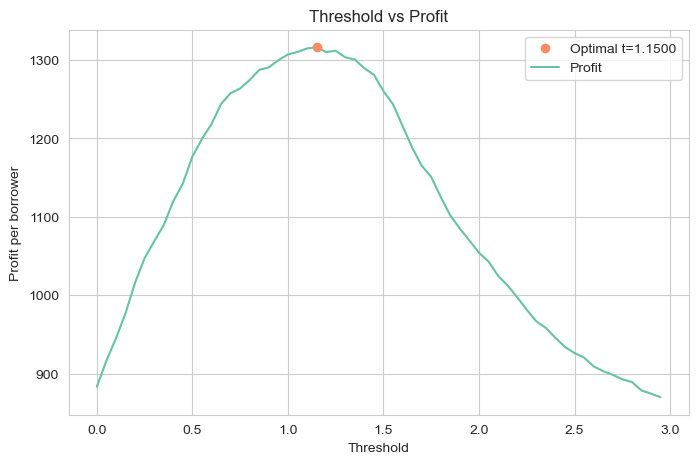

In [13]:
# Find optimal threshold
scored_df = score_dataframe(df_train_clean)
thresholds = np.arange(0,3,0.05)
profits = [compute_profit(t, scored_df) for t in thresholds]

# Find best threshold
optimal_threshold = thresholds[np.argmax(profits)]
optimal_profit = max(profits)
print(f"Optimal Threshold for Maximum Profit: {optimal_threshold:.4f}")
print(f"Maximum profit per prospective borrower: {round(optimal_profit,2):.4f}")


# Plot profit vs. threshold
sns.set_style("whitegrid")
sns.set_palette("Set2")

plt.figure(figsize=(8, 5))
plt.scatter(optimal_threshold, optimal_profit, color=sns.color_palette("Set2")[1], label=f'Optimal t={optimal_threshold:.4f}', zorder=2)
sns.lineplot(x=thresholds, y=profits, label="Profit", zorder=1)
plt.xlabel("Threshold")
plt.ylabel("Profit per borrower")
plt.title("Threshold vs Profit")
plt.legend()
plt.show()


### Evaluating from the bank's perspective

Now, we want to look at how this decision making system works on a test dataset. We'll apply all of the functions we used on the training set with the test set, and see what the profit per borrower will look like using the threshold from above, 1.15. 

In [14]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test, y_test, intent_map = preprocess(df_test)
df_test = new_features(df_test)
    
scored_test_df = score_dataframe(df_test)
print("profit per prospective borrower:", round(compute_profit(1.15, scored_test_df),2))

profit per prospective borrower: 1230.42


It looks like we ended up with a fairly similar profit per borrower on the test set to what we got from the train set, $1316 per borrower on the test set and $1230 on the train set. From the bank's perspective, this seems positive. If they are making, on average, $1230 per borrower, they would make around $6,000,000 off of this dataset of borrowers. 

### Evaluating from the borrower's perspective

Now, let's try to get a better understanding of who in the test dataset we are predicting is going to default on their loans, and who we are predicting is going to repay them. We'll look at the following questions: 

1. Is it more difficult for people in certain age groups to access credit under your proposed system?
2. Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that 3. group? What about people seeking loans for business ventures or education?
3. How does a person’s income level impact the ease with which they can access credit under your decision system?


#### Question 1

In [15]:
#| echo: false
scored_test_df = scored_test_df.dropna()

In [16]:
# Split the borrower ages into 4 buckets and see 
scored_test_df["age_group"] = pd.qcut(scored_test_df["person_age"], q=4, labels=["Young", "Middle-aged", "Older", "Senior"])
age_access = scored_test_df.groupby("age_group")["pred_default"].mean()
age_access

age_group
Young          0.171756
Middle-aged    0.121554
Older          0.142263
Senior         0.134460
Name: pred_default, dtype: float64

These probabilities are the mean of the prediction column, so they tell us the rate at which a 1 is predicted in each of the age buckets using our decision making system. That is, they tell us the loan rejection rate for each age group. We can see that younger people are mich more likely to be rejected for a loan than middle-aged and older people are, with a 17% rejection rate as opposed to a 12-14% rejection rate for older groups. 

#### Question 2

In [17]:
# Calculate rejection rates and actual default rates for loan intent
loan_intent_access = scored_test_df.groupby("loan_intent")["pred_default"].mean()
loan_intent_default_rates = scored_test_df.groupby("loan_intent")["loan_status"].mean()

loan_intent_df = pd.DataFrame({
    "Loan Intent (Decoded)": loan_intent_access.index.map(intent_map),
    "Rejection Rate": loan_intent_access.values,
    "Actual Default Rate": loan_intent_default_rates.values
})

In [18]:
# echo: false
loan_intent_df

,Loan Intent (Decoded),Rejection Rate,Actual Default Rate
0,DEBTCONSOLIDATION,0.150442,0.287611
1,EDUCATION,0.150510,0.167517
2,HOMEIMPROVEMENT,0.095779,0.250000
3,MEDICAL,0.164958,0.284250
4,PERSONAL,0.146293,0.220441
5,VENTURE,0.127593,0.146266


We're interested in the loans that are intended for medical uses. We can see that medical loans have the highest rate of rejection from our system (20% of medical loan requests are rejected), but they also have one of the highest rates of actual default (28%). Venture and business loans have lower rates of rejection and their actual default rates are closer to their rejection rates. 

#### Question 3

In [19]:
scored_test_df["income_group"] = pd.qcut(scored_test_df["person_income"], q=4, labels=["Low", "Lower-middle", "Upper-middle", "High"])
income_access = scored_test_df.groupby("income_group")["pred_default"].mean()

In [20]:
#| echo: false
income_access

income_group
Low             0.342638
Lower-middle    0.168044
Upper-middle    0.052274
High            0.004370
Name: pred_default, dtype: float64

Here, we are again looking at the loan rejection rates, this time by income group. It is clear that people with lower incomes are much more likely to be rejected using our decision making system (41% of the time), as opposed to high income people who are only rejected 0.8% of the time with our system. 

###  Write and Reflect 

We found from our model and evaluation that when we choose a threshold that optimizes the bank's profit, it can result in certain groups having a harder time obtaining a loan. We saw that age, income, and loan intent groups have differences rejection rates all with our decision making system. We can also see that optimizing profits for a bank requires turning a way a significant chunk of loan applications, because the reality is that many people do end up defaulting on their loans. In our decision-making process, we only considered 3 features of a person's application, but we found that these features correlated with certain groups having a harder time receiving a loan. This is a great example of a feature that is implicitly encoding information about another category. For example, a person's income could be correlated with what they are planning to use the loan for. Even though loan intent wasn't one of the features of our score function, we could see that different loan intents ended up with different rates of rejection in our system. So, is this system fair? We'll explore that by answering this question: Considering that people seeking loans for medical expense have high rates of default, is it fair that it is more difficult for them to obtain access to credit?

First, let's define fairness. I will define fairness in deciding who should get a loan of a combination of how much the person needs the loan and how likely it is that they will pay the loan back. If we are only basing fairness on how much the person needs the loan, we would likely say that people who need loans for medical reasons should all receive their loans. But, is this fair to the bank? They would end up losing a lot of money because people who take out loans for medical expenses often default on them. If we are only basing fairness on  how likely it is that they will pay the loan back, most people seeking medical loans probably shouldn't get them, because they do often default. But, in this case, very few people would receive medical loans, which seems unfair because they may be able to pay them back, even if people haven't historically paid medical loans back at a high rate. There are also some other confounding variables to consider, like whether people seeking medical loans are more likely to come from a historically marginalized group that might have a harder time proving they can pay a loan back or a smaller income on average than other groups? It may not be fair for these people to be subject to high rejection rates just because of their identity.  

  Ultimately, Looking at the rate of rejection versus the true rate of default for medical loans, I think it's fair that it may be more difficult for people to access these loans. The rate of default on these loans is much higher than the rate of default for loans with other intended purposes, so it seems that people who are seeking these loans may need to provide additional proof that they would be able to pay the loan back. It's fair for the bank to be skeptical. However, we can see that in our system, 80% of people seeking medical loans are being accepted. So it isn't the case that it's impossible for these people, who probably really need the loan, to obtain it. Therefore, I think it's fair that it is more difficult for people seeking medical loans to obtain access to credit given that they default much more frequently. 